<a href="https://colab.research.google.com/github/levdevs/desafio_programacion_java_2498412/blob/main/tp2/TP2_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports y carga de archivos

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import nltk
import re

In [11]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [12]:
train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train.csv')
train_df.head()

,ID,review_es,sentimiento
0,0,Uno de los otros críticos ha mencionado que de...,positivo
1,1,Una pequeña pequeña producción.La técnica de f...,positivo
2,2,Pensé que esta era una manera maravillosa de p...,positivo
3,3,"Básicamente, hay una familia donde un niño peq...",negativo
4,4,"El ""amor en el tiempo"" de Petter Mattei es una...",positivo


In [13]:
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test.csv')
test_df.head()

,ID,review_es
0,60000,La mayor virtud de esta película es su existen...
1,60001,"No soy un experto cinéfilo, pero pocas veces m..."
2,60002,Si no eres un incondicional del humor estilo T...
3,60003,"No sé qué está pasando, si la gente se deja ll..."
4,60004,"Pero cuando amanece,y me quedo solo,siento en ..."


In [14]:
# ----- PARAMETROS DEL OUTPUT -----
# MAX_ROWS: cantidad limite a mostrar, si se excede se resume (...)
# MIN_ROWS: cantidad de filas a mostrar pasado el corte
# MAX_COLWIDTH: ancho de columnas por cada output, si se excede se resume(...)

pd.reset_option("display.min_rows")
pd.reset_option("display.max_colwidth")
# pd.options.display.min_rows = 100000
# pd.options.display.max_colwidth = 1000

# Preprocesamiento de datos

Se deben limpiar y preprocesar los textos para que los modelos puedan manejarlos adecuadamente.

In [15]:
# Función de tokenización
# def tokenizer(text):
#     return [w for w in word_tokenize(text) if w.isalpha()] # si solo nos interesan palabras
#     return word_tokenize(text)

In [16]:
# DEBUG: almaceno cada una de las palabras
# global_tokens = []

# Creo copias del dataset para procesar
token_train_df = train_df.copy()
token_test_df = test_df.copy()

def preprocess_text(text):
    # Llevo texto a minúsculas
    text = text.lower()

    # Expresión regular para eliminar caracteres '¿', '¡', y '`'
    text = re.sub(r'[¡¿\`\']', ' ', text)

    # Expresión regular para separar palabras con puntos intermedios
    text = re.sub(r'([\wáéíóúü]+)\.+([\wáéíóúü]+)', r'\1 \2', text)

    # Tokenizacion
    tokens = word_tokenize(text, language='spanish')

    # Elimino signos de puntuación
    tokens = [word for word in tokens if word.isalpha()]

    # global_tokens.extend(tokens) # DEBUG
    return " ".join(tokens)

token_train_df['review_es'] = train_df['review_es'].apply(preprocess_text)
token_test_df['review_es'] = test_df['review_es'].apply(preprocess_text)

In [17]:
# DEBUG: operaciones sobre global_tokens

# len(global_tokens)

# Cuento cantidad de apariciones de palabras
# token_df = pd.DataFrame(global_tokens, columns=["Palabra"])
# token_df['Palabra'].value_counts()

# Para buscar reseñas específicas
# token_train_df.loc[(token_train_df['review_es'].str.contains('``')), 'review_es']

In [18]:
token_train_df.head()

,ID,review_es,sentimiento
0,0,uno de los otros críticos ha mencionado que de...,positivo
1,1,una pequeña pequeña producción la técnica de f...,positivo
2,2,pensé que esta era una manera maravillosa de p...,positivo
3,3,básicamente hay una familia donde un niño pequ...,negativo
4,4,el amor en el tiempo de petter mattei es una p...,positivo


In [19]:
token_test_df.head()

,ID,review_es
0,60000,la mayor virtud de esta película es su existen...
1,60001,no soy un experto cinéfilo pero pocas veces me...
2,60002,si no eres un incondicional del humor estilo t...
3,60003,no sé qué está pasando si la gente se deja lle...
4,60004,pero cuando amanece y me quedo solo siento en ...


# Definición de Stop Words

In [20]:
# Cargo las stopwords del corpus de NLTK
stoplist = stopwords.words('spanish')
stoplist_eng = stopwords.words('english')

# Tokenizo el stoplist con el mismo tokenizador del corpus principal
stoplist_tokenized = []
for w in (stoplist + stoplist_eng):
    stoplist_tokenized = stoplist_tokenized + word_tokenize(w)

# Armo una lista sin repeticiones
stoplist_tokenized = list(set(stoplist_tokenized))

# stoplist_tokenized
# len(stoplist + stoplist_eng)
# len(stoplist_tokenized)

# Entrenamiento de Bag of Words

Se utiliza este método para convertir el texto en vectores numéricos que puedan ser utilizados por los modelos de machine learning.

Cómo parámetro del CountVectorizer, puede indicarse la cantidad de tokens a incluir para formar n-gramas.

In [21]:
# Instanciamos un CountVectorizer con una tupla indicando el rango de los n-gramas a considerar
vectorizer = CountVectorizer(ngram_range=(1,2), min_df=5, stop_words=stoplist_tokenized)

# Usamos .fit_transform() para ajustar el CV y transformar los datos
X_train = vectorizer.fit_transform(token_train_df['review_es'])
y_train = token_train_df['sentimiento']

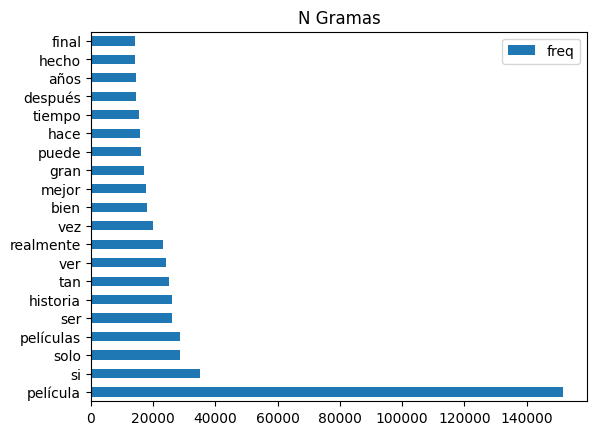

In [27]:
# Grafico frecuencias de términos de mayor a menor
import matplotlib.pyplot as plt
pd.DataFrame(X_train.sum(axis=0).T,
            index=vectorizer.get_feature_names_out(),
            columns=['freq']).sort_values(by='freq',
                                          ascending=False)[:20].plot(kind='barh',title='N Gramas');

In [29]:
# Muestro parte del vocabulario proporcionado
vocab = vectorizer.vocabulary_
vocab

{'críticos': 33352,
 'mencionado': 94134,
 'después': 40489,
 'ver': 161963,
 'solo': 145414,
 'oz': 107590,
 'episodio': 51995,
 'enganchado': 50720,
 'razón': 129331,
 'exactamente': 56905,
 'sucedió': 148353,
 'conmigo': 29502,
 'primera': 123366,
 'cosa': 31501,
 'golpeó': 65248,
 'brutalidad': 18415,
 'escenas': 52920,
 'violencia': 165761,
 'encuentran': 50422,
 'derecha': 39078,
 'palabra': 107957,
 'confía': 29402,
 'espectáculo': 54542,
 'débiles': 46915,
 'corazón': 31029,
 'tímido': 159484,
 'extrae': 58028,
 'punzones': 127592,
 'respecto': 133556,
 'drogas': 46226,
 'sexo': 140715,
 'hardcore': 69958,
 'uso': 160259,
 'clásico': 26484,
 'llama': 86544,
 'apodo': 8868,
 'dado': 35517,
 'seguridad': 138431,
 'máximo': 100688,
 'oswald': 107441,
 'centra': 23709,
 'principalmente': 123867,
 'ciudad': 25831,
 'emeralda': 49143,
 'sección': 137843,
 'experimental': 57678,
 'prisión': 124016,
 'todas': 155384,
 'células': 34944,
 'frentes': 62500,
 'vidrio': 165277,
 'enfrentan'

In [24]:
# Divido conjunto train para cross validation
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# XGBoost

In [96]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

In [97]:
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': 0.1,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'verbosity': 0
}

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_split)
y_val_encoded = label_encoder.transform(y_val_split)

dtrain = xgb.DMatrix(X_train_split, label=y_train_encoded)
dval = xgb.DMatrix(X_val_split, label=y_val_encoded)
model = xgb.train(params, dtrain, num_boost_round=1000, evals=[(dval, 'validation')], early_stopping_rounds=10, verbose_eval=False)


Evaluación del modelo:

In [98]:
y_pred = model.predict(dval)
y_pred_binary = [1 if pred > 0.5 else 0 for pred in y_pred]

Metricas:

In [99]:
y_val_pred_labels = label_encoder.inverse_transform(y_pred_binary)
y_val_true_labels = label_encoder.inverse_transform(y_val_encoded)

# Imprimir métricas de evaluación
print("Accuracy:", accuracy_score(y_val_true_labels, y_val_pred_labels))
print("Precision:", precision_score(y_val_true_labels, y_val_pred_labels, pos_label='positivo'))
print("Recall:", recall_score(y_val_true_labels, y_val_pred_labels, pos_label='positivo'))
print("F1 Score:", f1_score(y_val_true_labels, y_val_pred_labels, pos_label='positivo'))

print("Classification Report:\n", classification_report(y_val_true_labels, y_val_pred_labels))


Accuracy: 0.8728
Precision: 0.8656571539506892
Recall: 0.8848977971819806
F1 Score: 0.8751717369970561
Classification Report:
               precision    recall  f1-score   support

    negativo       0.88      0.86      0.87      4961
    positivo       0.87      0.88      0.88      5039

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



Realizar predicciones en el conjunto de prueba (test.csv)

In [100]:
X_test = vectorizer.transform(token_test_df['review_es'])
dtest = xgb.DMatrix(X_test)
test_predictions = model.predict(dtest)

Se decodifica las predicciones a etiquetas originales

In [101]:
test_predictions_labels = label_encoder.inverse_transform([1 if pred > 0.5 else 0 for pred in test_predictions])

Ahora se prepara el archivo csv para subrilo a kaggle

#Exportar CSV para Submission

In [102]:
# Creo nuevo DF con ID de reseña y predicción de sentimiento
output_df = pd.DataFrame({'ID': test_df['ID'], 'sentimiento': test_predictions_labels})
output_df

,ID,sentimiento
0,60000,negativo
1,60001,positivo
2,60002,negativo
3,60003,negativo
4,60004,negativo
5,60005,negativo
6,60006,negativo
7,60007,negativo
8,60008,negativo
9,60009,negativo


In [103]:
# Genero archivo CSV
output_df.to_csv('/content/drive/My Drive/Colab Notebooks/XGBoost-V3.csv', index=False)